In [1]:
import scanpy as sc
import anndata as ad
import os
import pickle
import pandas as pd
import numpy as np
import graphtools as gt
import phate
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import harmonypy as hm
from SCCAF import *
import diffxpy.api as de
import meld

np.random.seed(42)
font = {'size'   : 14}
mpl.rc('font', **font)

if os.path.isdir('/Users/mac/cloudstor/') == True:
    place = 'local'
    indir = '/Users/mac/cloudstor/sarah_projects/SCMDA231mets_chrcha/project_results/prefiltering/practice_all_data/'
    outdir = '/Users/mac/cloudstor/sarah_projects/SCMDA231mets_chrcha/project_results/sccaf/practice_all_data/'
    dataset = 'practice'
else:
    place = 'wolfpack'
    indir = '/share/ScratchGeneral/scoyou/sarah_projects/SCMDA231mets_chrcha/project_results/prefiltering/all_data/'
    outdir = '/share/ScratchGeneral/scoyou/sarah_projects/SCMDA231mets_chrcha/project_results/sccaf/all_data/'
    dataset = 'all'

print('Place: ', place,
       'indir: ', indir,
       'outdir: ', outdir)

sc.settings.autosave = True
sc.settings.figdir = outdir

Place:  local indir:  /Users/mac/cloudstor/sarah_projects/SCMDA231mets_chrcha/project_results/prefiltering/practice_all_data/ outdir:  /Users/mac/cloudstor/sarah_projects/SCMDA231mets_chrcha/project_results/sccaf/practice_all_data/


Make an ANNDATA object from matrix files exported from single experiment object

#### Load counts filtered for lowly expressed genes and low quality cells (2MAD each sample library size, gene counts, 2MAD whole experiment mito content).

Load ANNDATA object containing filtered counts, otherwise make one from csv and matrix files

In [2]:
if os.path.isfile(os.path.join(indir, 'Prefiltered_experiment_' + str(dataset) + '_filtered_counts_AnnData.h5ad')) == True:
    sdata = ad.read_h5ad(os.path.join(indir, 'Prefiltered_experiment_' + str(dataset) + '_filtered_counts_AnnData.h5ad'))
else:
    sdata = ad.read_mtx(os.path.join(indir, 'Prefiltered_experiment_' + str(dataset) + '_filtered_counts.mtx')).T
    pd_obs = pd.read_csv(os.path.join(indir, 'Prefiltered_experiment_' + str(dataset) + '_colData.csv'), index_col=0, header=0)
    cat_reps = pd_obs['Replicate'].astype(str)
    pd_obs.loc[:, ('Replicate')] = cat_reps
    pd_var = pd.read_csv(os.path.join(indir, 'Prefiltered_experiment_' + str(dataset) + '_rowData.csv'), index_col=0, header=0)
    sdata.obs = pd_obs
    sdata.var = pd_var
    sdata.write(os.path.join(indir, 'Prefiltered_experiment_' + str(dataset) + '_filtered_counts_AnnData.h5ad'))

sdata

AnnData object with n_obs × n_vars = 7055 × 12483
    obs: 'Sample', 'Barcode', 'old_Sample', 'Tissue', 'Replicate', 'cellIDs', 'Human_percent', 'Human_cells', 'Lib_size', 'Genes_detected', 'Mito_percent', 'Practice_subset', 'Mito_percent_discard', 'Genes_detected_discard', 'Libsize_discard', 'discard'
    var: 'ID', 'Symbol', 'Type', 'GeneSymbol', 'Organism', 'Ensembl', 'Liver_active', 'LN_active', 'Lung_active', 'Primary_active', 'Any_Active'

Normalise and log transform counts

In [3]:
sc.pp.normalize_total(sdata, target_sum=1e4)

In [4]:
sc.pp.log1p(sdata)

Identify variable genes (first within batch and then merged)

In [5]:
sc.pp.highly_variable_genes(sdata, n_top_genes=5000, batch_key='Replicate')

/Users/mac/local/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
/Users/mac/local/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/mac/local/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/mac/local/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Us

Save a copy of the whole dataset for differential expression testing

In [6]:
sdata.raw = sdata

Subset to HVG, regress out library size factors and scale the data (clipping to 10 SD above mean)

In [7]:
sdata = sdata[:, sdata.var.highly_variable]
#sc.pp.regress_out(sdata, ['Lib_size'])
sc.pp.scale(sdata, max_value=10)

/Users/mac/local/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/mac/local/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:848: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


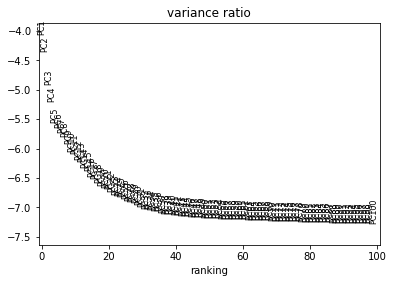

In [8]:
sc.tl.pca(sdata, svd_solver='arpack', n_comps=100, random_state=42)
sc.pl.pca_variance_ratio(sdata, log=True, n_pcs=100)

In [9]:
ho = hm.run_harmony(sdata.obsm['X_pca'], sdata.obs, 'Replicate', plot_convergence=True, max_iter_kmeans=100, random_state=42)
sdata.obsm["X_pca_harmony"] = np.transpose(ho.Z_corr)

2020-08-03 17:55:45,215 - harmonypy - INFO - Iteration 1 of 100
2020-08-03 17:55:51,288 - harmonypy - INFO - Iteration 2 of 100
2020-08-03 17:55:56,114 - harmonypy - INFO - Iteration 3 of 100
2020-08-03 17:55:58,156 - harmonypy - INFO - Iteration 4 of 100
2020-08-03 17:55:59,637 - harmonypy - INFO - Iteration 5 of 100
2020-08-03 17:56:01,227 - harmonypy - INFO - Converged after 5 iterations


In [10]:
#G = gt.Graph(np.array(sdata.obsm["X_pca"]), decay=40, knn=10, n_pca=None, n_jobs=-2, verbose=True, random_state=42)
#phate_op = phate.PHATE(knn_dist='precomputed', t='auto', gamma=1, n_jobs=-2, n_components=2, random_state=42, n_pca=None)
#data_phate = phate_op.fit_transform(G.kernel)
#sdata.obsm["X_phate_nobatch"] = data_phate[0:,0:]
#sc.pl.embedding(sdata, "X_phate_nobatch", color=['Replicate', 'Tissue'])

Calculating KNN search...
Calculated KNN search in 1.87 seconds.
Calculating affinities...
Calculated affinities in 0.63 seconds.
Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 7055 cells.
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 0.07 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.49 seconds.
    Calculating KMeans...
    Calculated KMeans in 33.08 seconds.
  Calculated landmark operator in 36.20 seconds.
  Calculating optimal t...
  Calculated optimal t in 3.59 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.01 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 9.58 seconds.
Calculated PHATE in 50.45 seconds.


/Users/mac/local/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


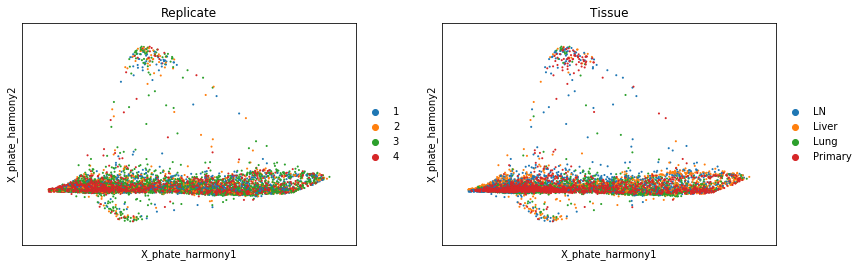

In [11]:
G = gt.Graph(np.array(sdata.obsm["X_pca_harmony"]), decay=40, knn=15, n_pca=None, n_jobs=-2, verbose=True, random_state=42)
phate_op = phate.PHATE(knn_dist='precomputed', t='auto', gamma=1, n_jobs=-2, n_components=2, random_state=42, n_pca=None)
data_phate = phate_op.fit_transform(G.kernel)
sdata.obsm["X_phate_harmony"] = data_phate[0:,0:]
sc.pl.embedding(sdata, "X_phate_harmony", color=['Replicate', 'Tissue'], save='.Cell_clustering_Harmony_batch_correction.png')

/Users/mac/local/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


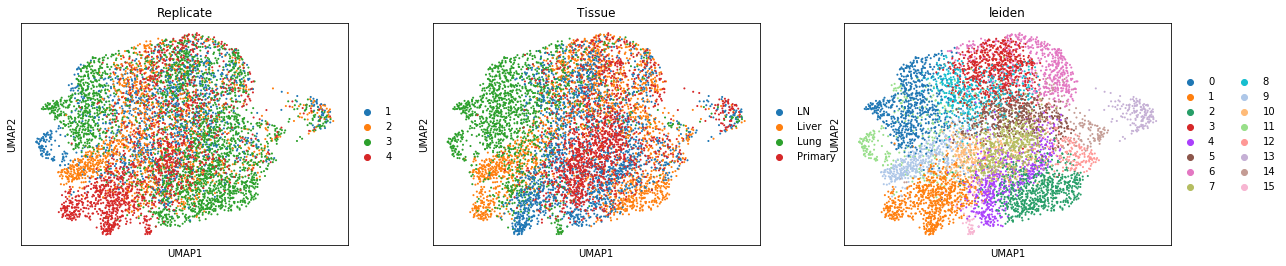

In [12]:
sc.pp.neighbors(sdata, n_neighbors=15, n_pcs=100, use_rep='X_pca', random_state=42)
sc.tl.leiden(sdata, random_state=42)
sc.tl.umap(sdata, random_state=42)
sc.pl.umap(sdata, color=['Replicate', 'Tissue', 'leiden'], save='.Cell_clustering_no_batch_correction.png')

/Users/mac/local/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


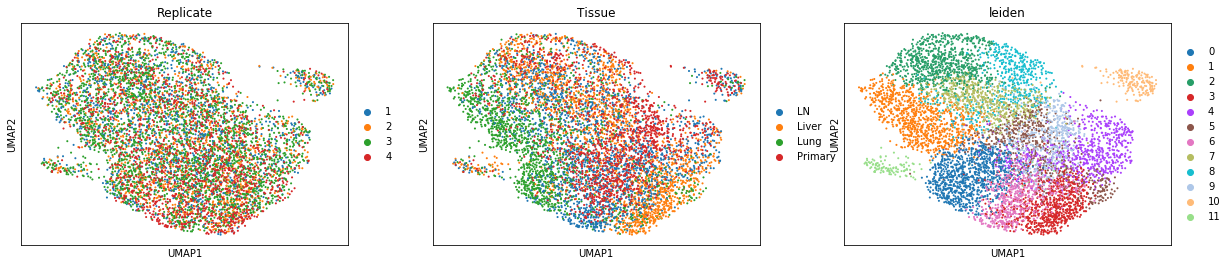

In [13]:
sc.pp.neighbors(sdata, n_neighbors=15, n_pcs=100, use_rep='X_pca_harmony', random_state=42)
sc.tl.leiden(sdata, random_state=42)
sc.tl.umap(sdata, random_state=42)
sc.pl.umap(sdata, color=['Replicate', 'Tissue', 'leiden'], save='.Cell_clustering_Harmony_batch_correction_preSCCAF.png')

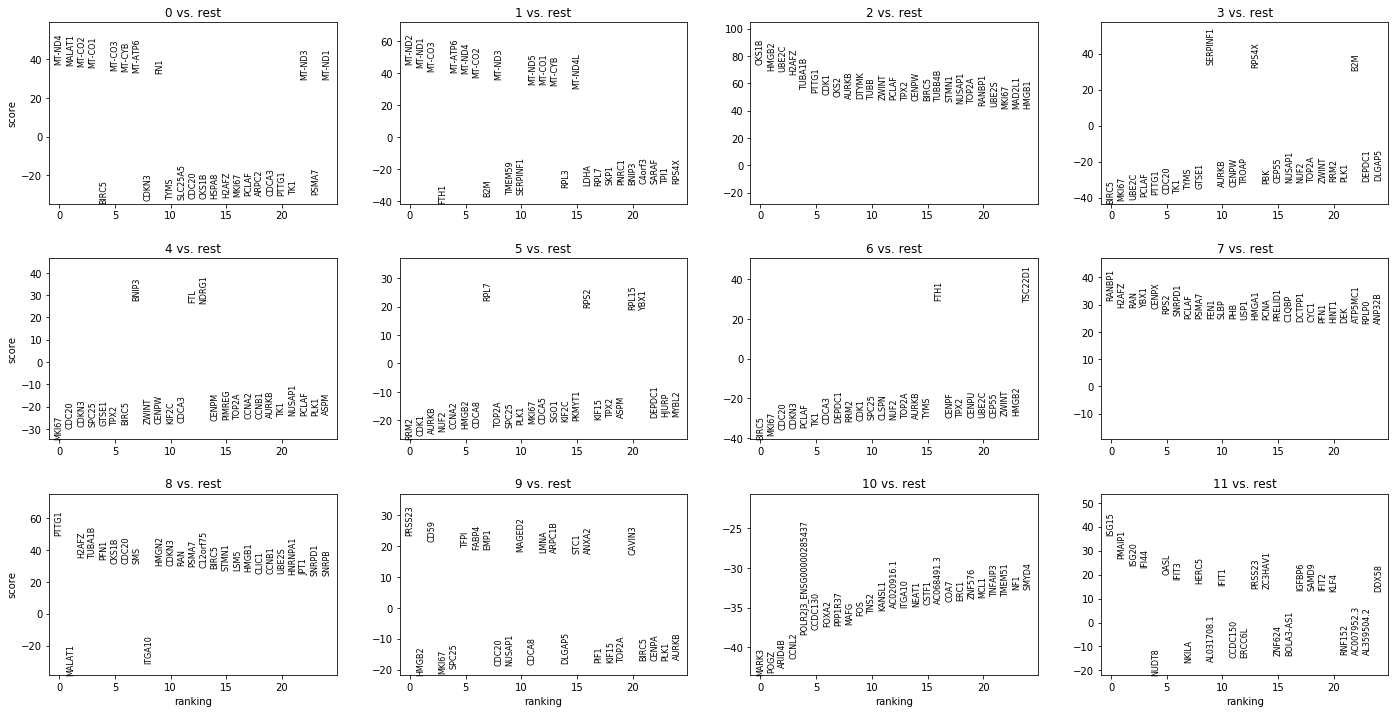

In [14]:
sc.tl.rank_genes_groups(sdata, 'leiden', method='t-test', rankby_abs=True)
sc.pl.rank_genes_groups(sdata, n_genes=25, sharey=False, save='.Top_markers_preSCCAF.png')

/Users/mac/local/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


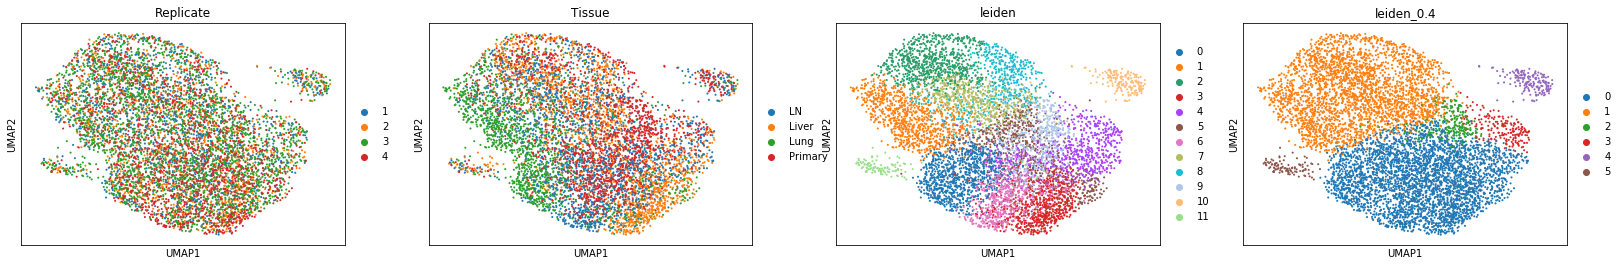

In [15]:
sdata.obs['L1_Round0'] = sdata.obs['leiden']
sc.tl.leiden(sdata, resolution=0.4, key_added='leiden_0.4', random_state=42)
sc.pl.umap(sdata, color=['Replicate', 'Tissue', 'leiden', 'leiden_0.4'], save='.Cell_clustering_Harmony_batch_correction_leiden_low_res.png')

/Users/mac/local/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mac/local/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


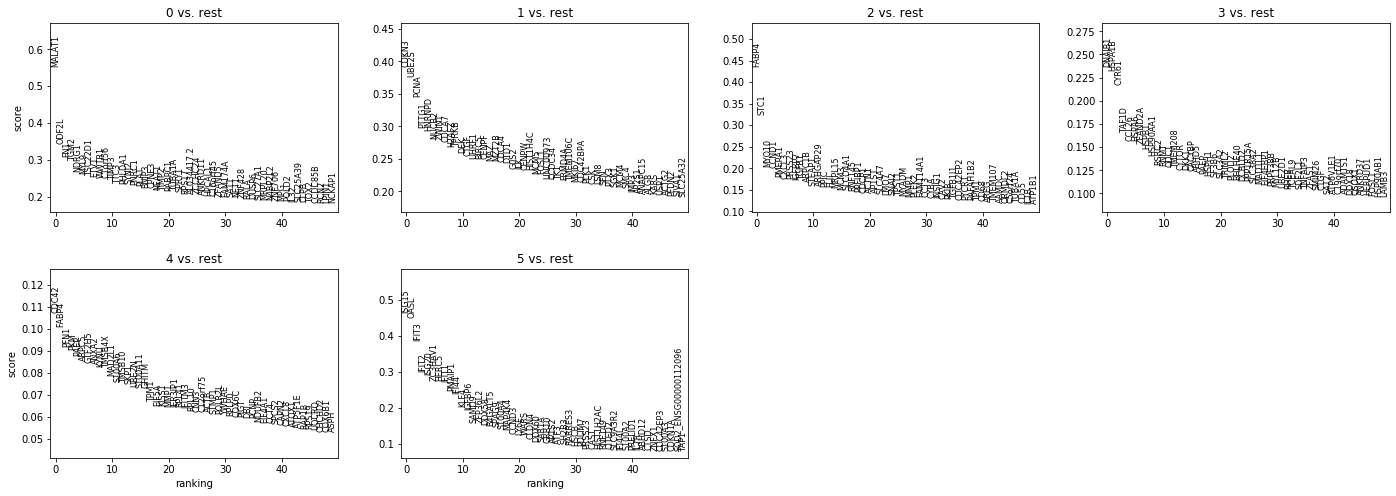

In [16]:
sc.tl.rank_genes_groups(sdata, 'leiden_0.4', method='logreg')
sc.pl.rank_genes_groups(sdata, n_genes=50, sharey=False, save='.Top_markers_leiden_low_res.png')

In [17]:
SCCAF_optimize_all(min_acc=0.9, ad=sdata, basis ='umap', start='L1_Round0', low_res='leiden_0.4', prefix='L1', plot=False)

R1norm_cutoff: 0.500000
R2norm_cutoff: 0.050000
Accuracy: 0.000000
Round1 ...
Mean CV accuracy: 0.6675
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.6807
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.6870
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.6817
Max R1mat: 0.217082
Max R2mat: 0.021960
min_acc: 0.680685
IGRAPH U-W- 12 0 --
+ attr: weight (e)
Converge SCCAF_optimize no. cluster!
m1: 0.217082
m2: 0.021960
Accuracy: 0.680685
R1norm_cutoff: 0.207082
R2norm_cutoff: 0.020960
Accuracy: 0.680685
Round1 ...
Mean CV accuracy: 0.6935
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.6819
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.6776
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.6805
Max R1mat: 0.268371
Max R2mat: 0.021685
min_acc: 0.677633
IGRAPH U-W- 12 2 --
+ attr: weight (e)
+ edges:
3--6 3--6
Round2 ...
Mean CV accuracy: 0.7467
Accuracy on the tra

/Users/mac/local/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'L1_Round0_self-projection' as categorical
... storing 'L1_result' as categorical
... storing 'L1_Round1' as categorical
... storing 'L1_Round1_self-projection' as categorical
... storing 'L1_Round2' as categorical
... storing 'L1_Round2_self-projection' as categorical
... storing 'L1_Round3' as categorical
... storing 'L1_Round3_self-projection' as categorical
... storing 'L1_Round4' as categorical
... storing 'L1_Round4_self-projection' as categorical


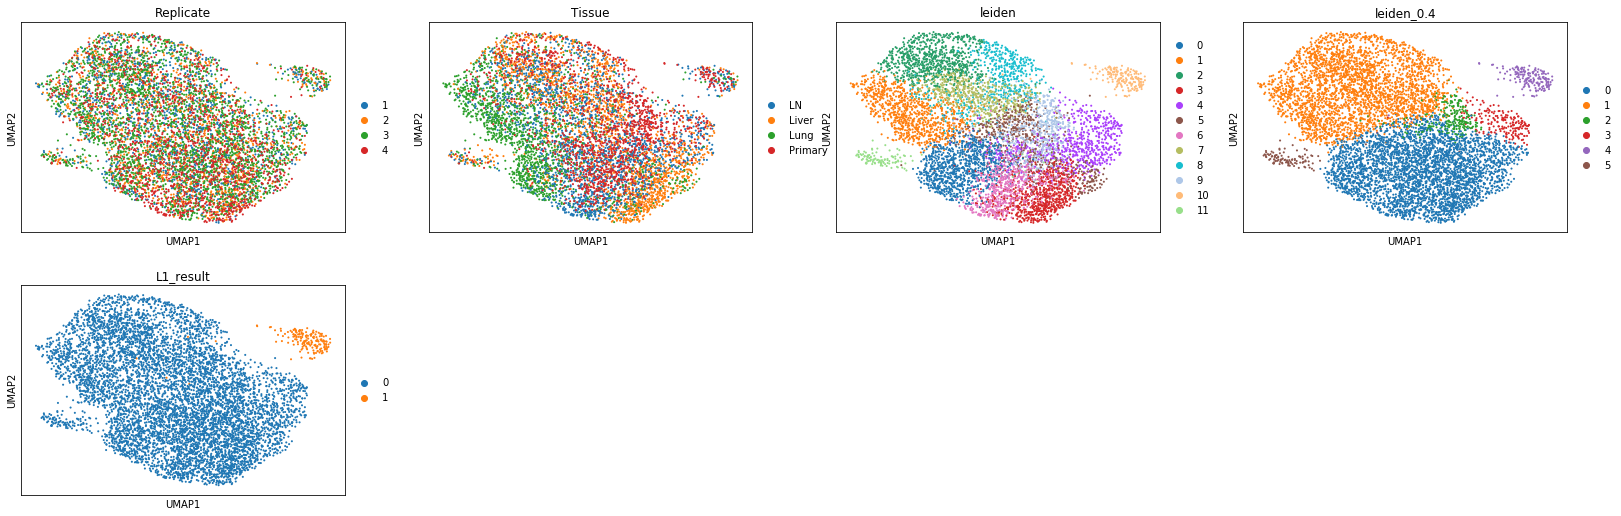

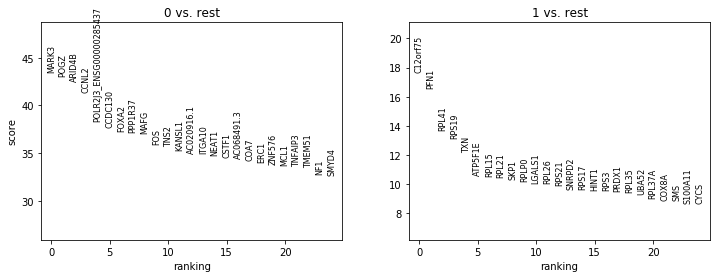

In [18]:
sc.pl.umap(sdata, color=['Replicate', 'Tissue', 'leiden', 'leiden_0.4', 'L1_result'], save='.Cell_clustering_Harmony_batch_correction_postSCCAF.png')
sc.tl.rank_genes_groups(sdata, 'L1_result', method='t-test', use_raw=True)
sc.pl.rank_genes_groups(sdata, n_genes=25, sharey=False, save='.Top_markers_postSCCAF.png')

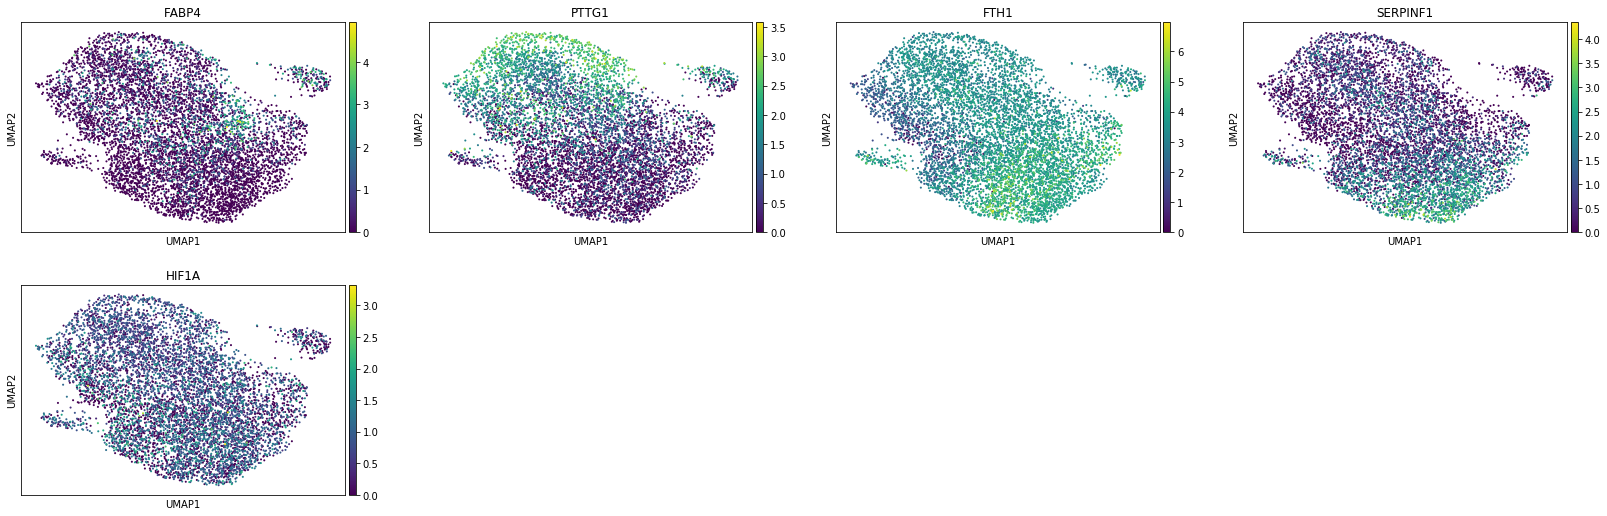

In [19]:
sc.pl.umap(sdata, color=['FABP4', 'PTTG1', 'FTH1', 'SERPINF1', 'HIF1A'])

Calculating KNN search...
Calculated KNN search in 1.37 seconds.
Calculating affinities...
Calculated affinities in 0.50 seconds.
Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 7055 cells.
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 0.06 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.14 seconds.
    Calculating KMeans...
    Calculated KMeans in 24.69 seconds.
  Calculated landmark operator in 27.36 seconds.
  Calculating optimal t...
  Calculated optimal t in 2.67 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.75 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 10.64 seconds.
Calculated PHATE in 41.50 seconds.


/Users/mac/local/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


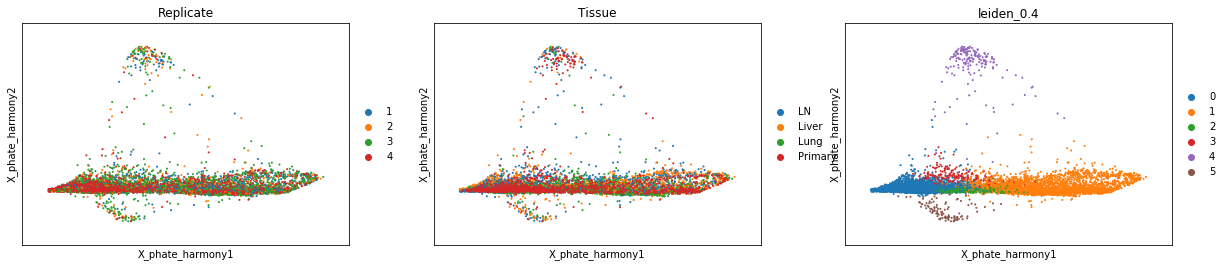

In [21]:
G = gt.Graph(np.array(sdata.obsm["X_pca_harmony"]), decay=40, knn=15, n_pca=None, n_jobs=-2, verbose=True, random_state=42)
phate_op = phate.PHATE(knn_dist='precomputed', t='auto', gamma=1, n_jobs=-2, n_components=2, random_state=42, n_pca=None)
data_phate = phate_op.fit_transform(G.kernel)
sdata.obsm["X_phate_harmony"] = data_phate[0:,0:]
sc.pl.embedding(sdata, "X_phate_harmony", color=['Replicate', 'Tissue', 'leiden_0.4'], save='.Cell_clustering_Harmony_batch_correction_phate.png')

In [22]:
sdata.write(os.path.join(outdir, 'Prefiltered_experiment_' + str(dataset) + '_normalised_AnnData_SCCAF.h5ad'))